 # Homework 2
 
by Franklin Marsh

MATH0154

Computational Statistics

with Prof. 😍Gabe Chandler😍

 # Problem 1

 ## Part (a)

$P(k + 1) = \frac{n!}{(k + 1)!(n - k - 1)!}\times p^{k + 1}(1 - p)^{n - k - 1} = \frac{n!}{k!(n-k)!} \times p^{k}(1-p)^{n-k} \times c $

If we solve this equation for c and substitute, here is what we get:

$P(k + 1) = \frac{p \times (n-k)}{(k+1)(1-p)} \times P(k)$

We will write this into our NextTerm function.

 ## Part (b)

In [469]:
NextTerm <- function(prev,p,n,k) {
    
    # Calculates binomial probability p(n,k+1) if given p(n,k)
    #
    # Args:
    #     prev: p(n,k)
    #     p: probability between 0 and 1, 0.5 for coin flip.
    #     n: total number of trials
    #     k: number of succesful trials
    # Returns:
    #     p(n,k+1): next binomial probability
    
    return(((p*(n-k))/((k+1)*(1-p)))*prev) #return the formula
}

This next function will draw $m$ random variables from the binomial distribution using the discrete inverse transform.

In [517]:
DrawBinomial <- function(p,m,n) {
    
    #Performs m experiments on a binomial distribution with n trials and probability p
    #
    # Args:
    #     p: probability between 0 and 1, 0.5 for coin flip.
    #     n: total number of trials per experiment
    #     m: total number of experiments
    #
    # Returns:
    #     out: results of experiments in a vector of length m.
    
    out <- c() #initialize the output vector as empty
        
    for (num in (1:m)) { #for each trial
        
        P <- c((1-p)^(n)) #calculate the starting P0
        U <- runif(1) #draw a uniform
        CDF <- P #add P0 to the cdf
        k <- 0 #start k at 0
    
        while (U > CDF) { #while the uniform is still greater than the accumulated CDF
            P <- NextTerm(P, p, n, k) #calculate the next probability
            CDF <- P + CDF #and add it to the cdf
            k <- k + 1 # add 1 to k
        }
        
        out[num] <- k #append k to the output vector
    }
    
    return(out)
}

Draw some random binomials! Looks good! 💯

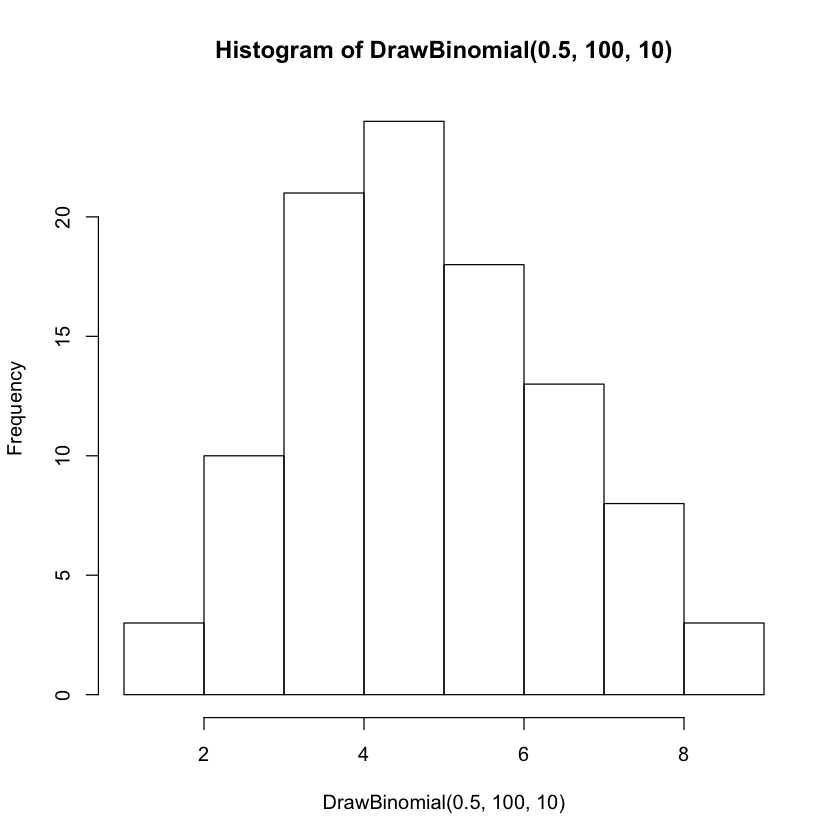

In [523]:
hist(DrawBinomial(0.5,100,10))

 # Problem 2

 ## Part (a)

The CDF of a single exponential distribution is $F(x) = 1 - e^{-\lambda x}$. 

Using the symmetry of the uniform distribution, $U = 1 - e^{-\lambda x} \Rightarrow x = \frac{log(u)}{\lambda}$

In [376]:
DoubleExponential <- function(lambda, n_iters) {
    
    # Draw random variables from a double exponential distribution with parameter lambda
    #
    # Args:
    #     lambda: double exponential scale factor.
    #     n_iters: number of desired random variates.
    #
    # Returns:
    #     x: vector of random variates with length m.
    
    x <- c()
    
    sign <- runif(n_iters) #initialize a random uniform to choose sign
    val <- runif(n_iters) #initialize a random uniform to generate value
    
    for (i in (1:n_iters)) {
        
    if (sign[i] > 0.5) {
        x[i] <- log(val[i])/lambda 
    }
    else if (sign[i] < 0.5) {
        x[i] <- -log(val[i])/lambda    
    }
        
    }
    
    return (x)
}

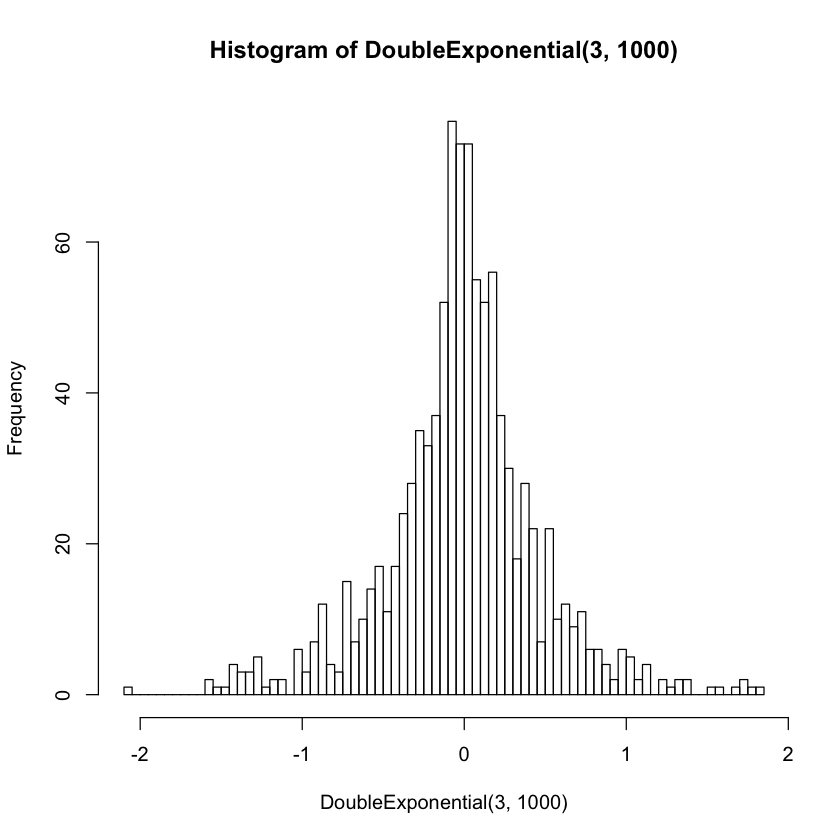

In [198]:
hist(DoubleExponential(3, 1000), breaks = 100)

Looks good! 

 ## Part (b)

We'll need the pdf of both the masking distribution (Double Exponential Distribution), and the target distribution (Normal Distribution).

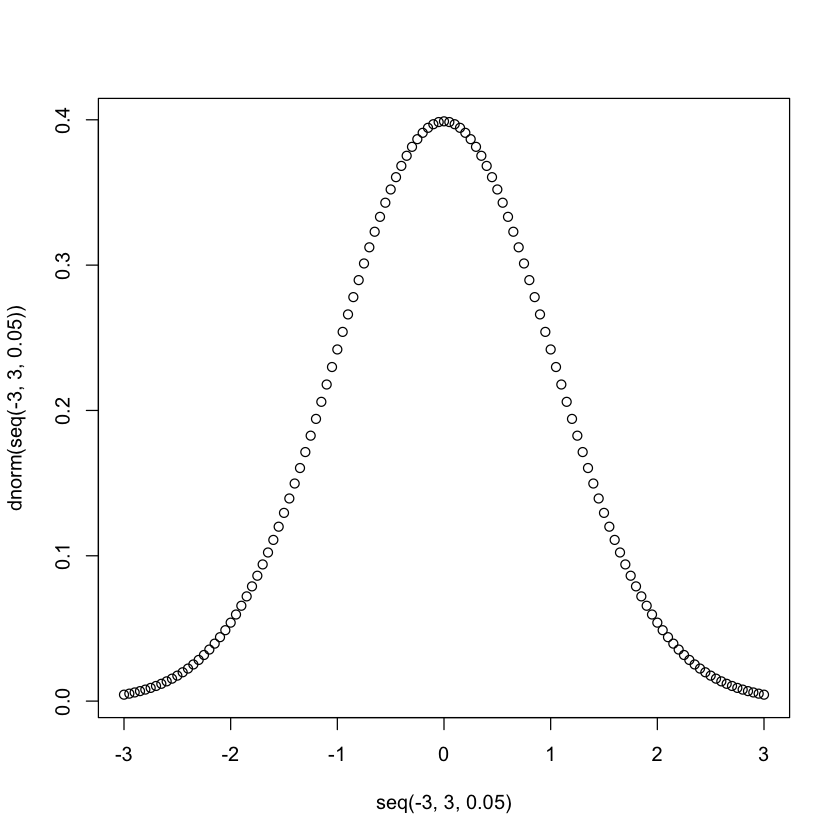

In [210]:
plot(seq(-3,3,0.05),dnorm(seq(-3,3,0.05)))

In [524]:
DE_pdf <- function(x, lambda = 1) {
    
    # Calculates Double Exponential probability density function
    #
    # Args:
    #     x: evaluate the pdf for this x-value.
    #     lambda: the scale factor of the double exponential distribution.
    
    return((lambda/2.0)*exp(1)^(-lambda*abs(x)))
    
}

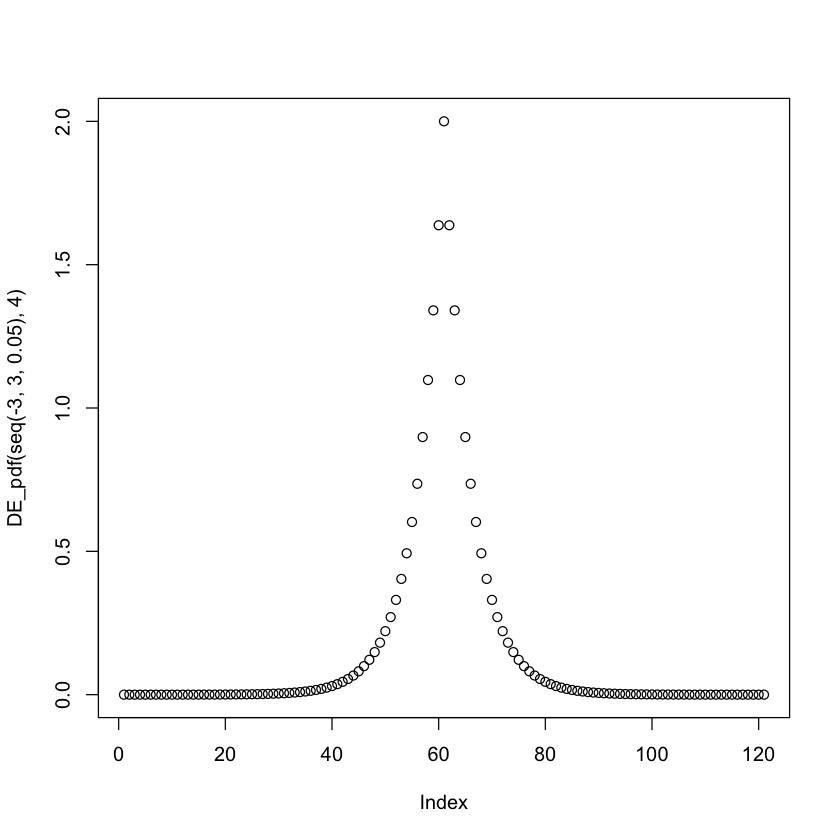

In [217]:
plot(DE_pdf(seq(-3,3,0.05),4))

In [225]:
FindC <- function(maskpdf, targetpdf, param1, prange = seq(-3,3,0.01), by = 0.01) {
    
    # Finds the normalizing coefficient c for drawing using the masking technique
    #
    # Args:
    #     maskpdf:
    #     targetpdf:
    #     param1:
    #     prange:
    #     by:
    # Returns:
    #     c: normalizing coefficient
    
    grid <- seq(min(prange),max(prange), by)
    
    c <- max((targetpdf(grid))/(maskpdf(grid, param1)))
    
    return(c)
}

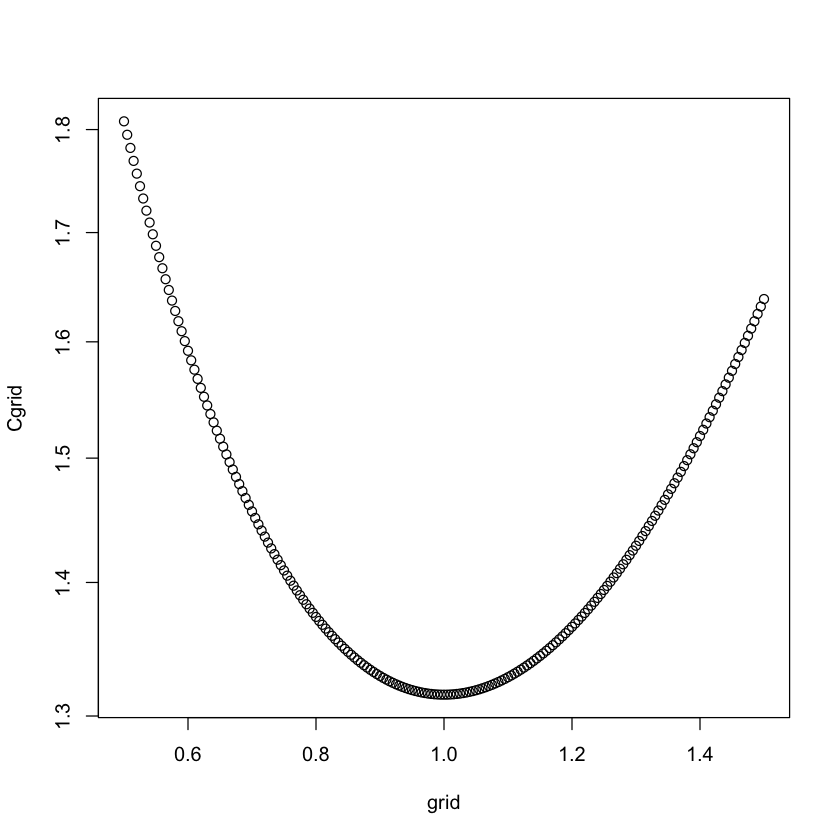

In [240]:
grid <- seq(0.5,1.5, 0.005) #test over a range of many lambda values
Cgrid <- c() #create empty array to store c calculate for many lambda values
i <- 0 # initialize empty variable to populate Cgrid

for (lambda in grid) {
        i <- i + 1
        Cgrid[i] <- FindC(DE_pdf, dnorm, lambda)
}

plot(grid,Cgrid, log = 'y') 

This grid search tells us that the C to use is about 1.3154... We also seem to have to set $\lambda = 1$ to achieve this low C.

In [298]:
min(Cgrid) #find the minimum of this grid search. This is our C

[1] 1.315489

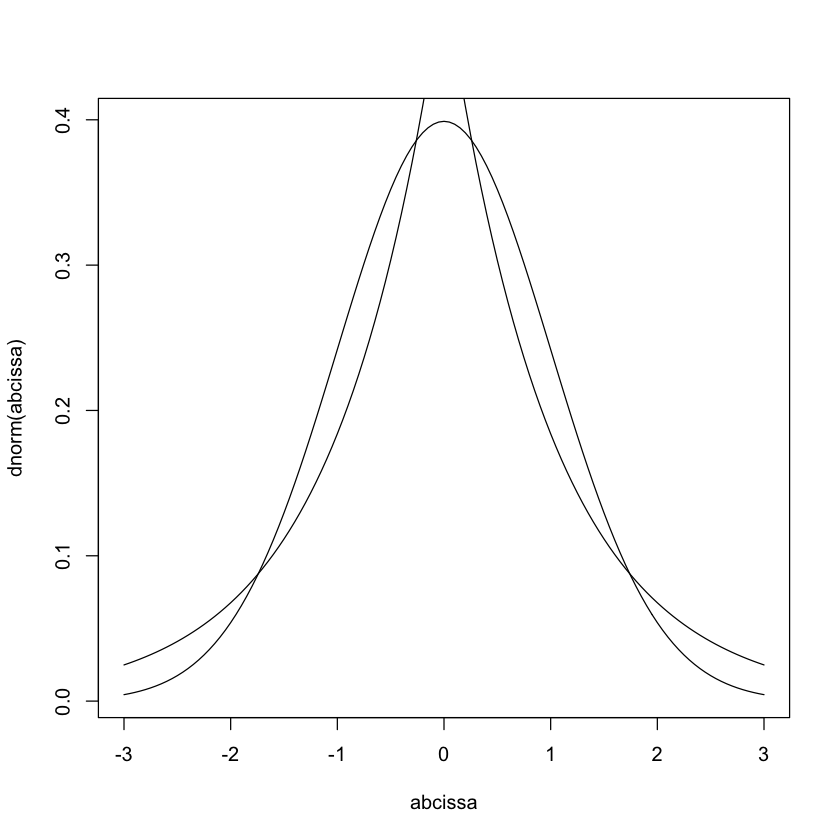

In [459]:
abcissa <- seq(-3,3,0.05) #create some abcissa values to plot two pdfs.

plot(abcissa,dnorm(abcissa), type = 'l')
par(new = T)
lines(abcissa,DE_pdf(abcissa, 1.0), type = 'l')
par(new = F)

Above is are the two PDFs drawn on the same axis.

 ## Part (c)

In [293]:
MaskingDraw <- function(maskdraw, maskpdf, goalpdf, c, n_iters) {
    
    # Draw from pdf (goalpdf) using the masking technique
    # 
    # Args:
    #     maskdraw: a function that draws from the masking dist.
    #     maskpdf: a function that returns the pdf of the masking dist when given an x.
    #     goalpdf: the pdf of the function that we are trying draw from
    #     c: the c normalizing constant for maskpdf and goalpdf
    #     n_iters: number of points that we want to draw
    #
    # Returns:
    #     out: randoom numbers like they were drawn from goalpdf
    
    out <- c() #initialize empty output
        
    for (i in (1:n_iters)) {
        
        pull <- maskdraw(lambda = 1, 1) #the initial value we are pulling from the masking distribution
        crit <- (goalpdf(pull))/(c*maskpdf(pull))
        
        U <- runif(1)
        
        if (U <= crit) {
            out[i] <- pull
            }
    }
    return(out)
    }


In [295]:
sd(na.omit(MaskingDraw(DoubleExponential, DE_pdf, dnorm, min(Cgrid), 10000)))

[1] 1.00032

The resulting distribution has a standard deviation of one. Here is how the histogram looks:

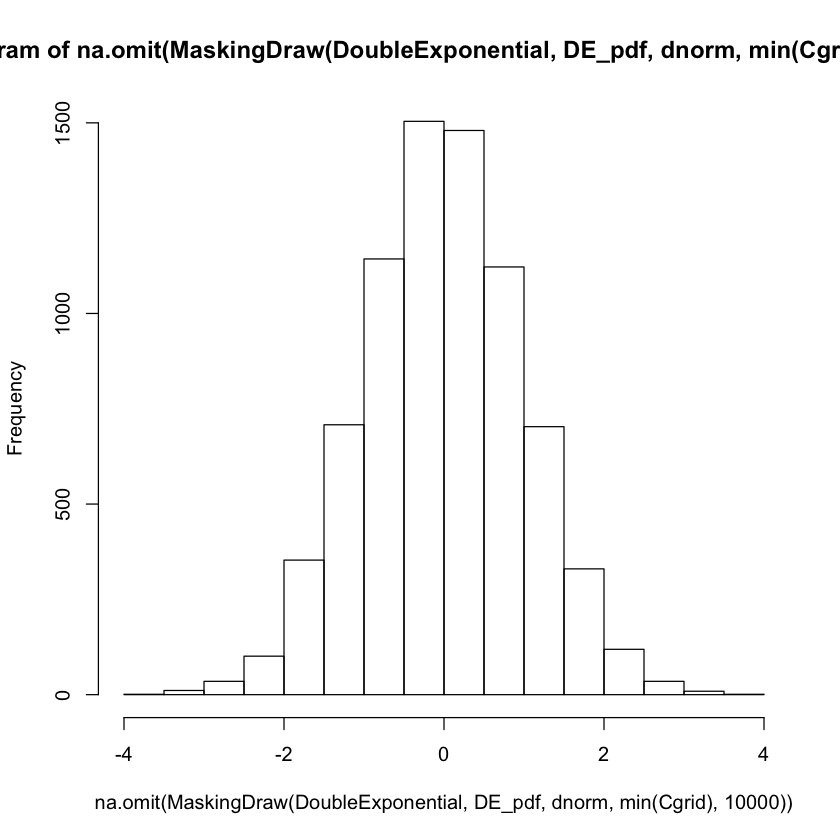

In [299]:
hist(na.omit(MaskingDraw(DoubleExponential, DE_pdf, dnorm, min(Cgrid), 10000)))

In [300]:
mask_draws <- MaskingDraw(DoubleExponential, DE_pdf, dnorm, min(Cgrid), 10000)

In [303]:
rejection_probability <- (length(mask_draws) - length(na.omit(mask_draws)))/length(mask_draws)
print(rejection_probability)

[1] 0.2332


For C = 1.3155, about 23.32% of the draws were rejected by the masking process.

 # Problem 3

In [483]:
MapPDF <- function(u, alpha, theta) { 
    
    # Maps uniforms to a new pdf as described in problem 3:
    #
    # f(x) = alpha*x^(\theta)
    #
    # Args:
    #    u: The input uniform that is to be mapped
    #    alpha: the 'alpha' parameter in the pdf definition
    #    theta: the 'theta parameter in the pdf definition
    # Returns:
    #    out: a float of the mapped uniform
    
    return(((u*(theta + 1))/alpha)^(1/(theta + 1)))
    }

We are taking the function $x = (\frac{u(\theta + 1)}{\alpha})^{\frac{1}{\theta + 1}}$

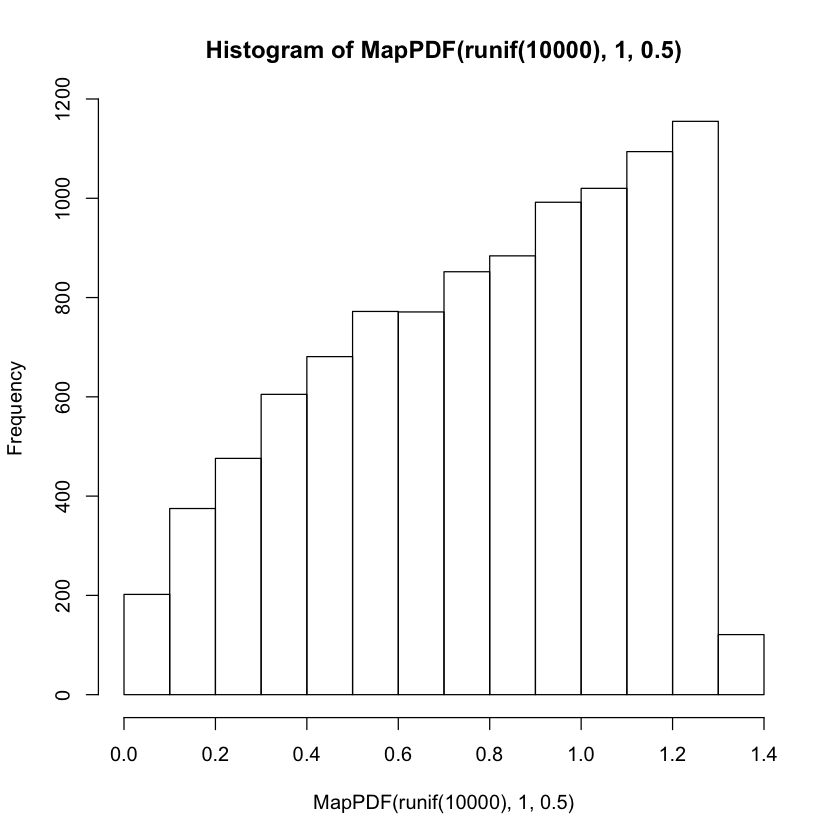

In [484]:
hist(MapPDF(runif(10000), 1,0.5))

 # Problem 4

In [335]:
pdf <- function(x, theta = 0, c = 2*pi) { 
    
    # Evaluates the PDF in problem 4
    #
    # Args:
    #    x: point to evaluate pdf 
    #    theta: phase offset in input funciton
    #    c: normalization constant, defaults to 1
    #
    # Returns:
    #    pdf(x): pdf evaluated at x
    
    return((1 - cos(x - theta))/(c))
                
}
    

StochasticIntegral <- function(pdf, prange = c(0,2*pi), n_iters) {
    
    # Performs stochastic (monte carlo) integration
    #
    # Args:
    #    pdf: the function to integrate
    #    prange: the range of x values to integrate over
    #    n_iters: number of draws to perform to evaluate the integral
    #
    # Returns:
    #    integral: the stochastic estimate of the integral
    
    V <- max(prange) - min(prange)
    hold <- c() #hold 
    i <- 0
    for (U in runif(n_iters)*V) {
        i <- i + 1
        hold[i] <- pdf(U, 0)  
    }
    
     return((sum(hold)/n_iters)*V)
}

  ## Part (a)

In [179]:
StochasticIntegral(pdf, n_iters = 10000)

[1] 6.266037

Looks like the normalization constant needs to be $2\pi$

  ## Part (b)

The likelihood:
$L(\theta) = \Pi_{i = 1}^{n}\Bigg(\frac{1 - \cos(x_{i} - \theta)}{2\pi}\Bigg)$


The log-likelihood:
$l(\theta) = \log(L(\theta)) = \sum_{i = 1}^{n}\log\Bigg(\frac{1 - \cos(x_{i} - \theta)}{2\pi}\Bigg)$

  ## Part (c)

$\frac{d}{d\theta}\Bigg( \log(L(\theta)) \Bigg) = \sum_{i = 1}^{n} \cot \Bigg(\frac{(x_{i} - \theta)}{2} \Bigg)$

$\frac{d}{d^{2}\theta}\Bigg( \log(L(\theta)) \Bigg) = - \frac{1}{2} \sum^{n}_{i = 1} \csc^{2} \Bigg(\frac{x_{i} - \theta}{2} \Bigg) $

  ## Part (d)

In [346]:
FindC_2 <- function(maskpdf, goalpdf, prange = c(0.01,2*pi - 0.01), by = 0.01) {
    
    # See FindC.
    
    grid <- seq(min(prange),max(prange), by)
    
    c <- max((goalpdf(grid))/(maskpdf(grid, min = min(prange), max = max(prange))))
    
    return(c)
}

In [340]:
C2 <- FindC_2(dunif, pdf, by = 0.001)
print(C2)

[1] 1.993634


It appears that 2 is a good choice for c.

In [358]:
DrawPDF <- function(n_iter) {
    
    # A sloppy function that only draws from the pdf in this function. Do not port to another R script.
    #
    # Args:
    #     n_iters: number of random variates desired
    # Returns:
    #     out: vector of length n_iters of the random variates.
    
    
    out <- c()
        
    for (i in (1:n_iter)) {
        
        pull <- runif(1,min = 0, max = 2*pi) #the initial value we are pulling from the masking distribution
        crit <- (2*pi*pdf(pull))/C2
        
        U <- runif(1)
        
        if (U <= crit) {
            out[i] <- pull
            }
        }
    return(out)
    }


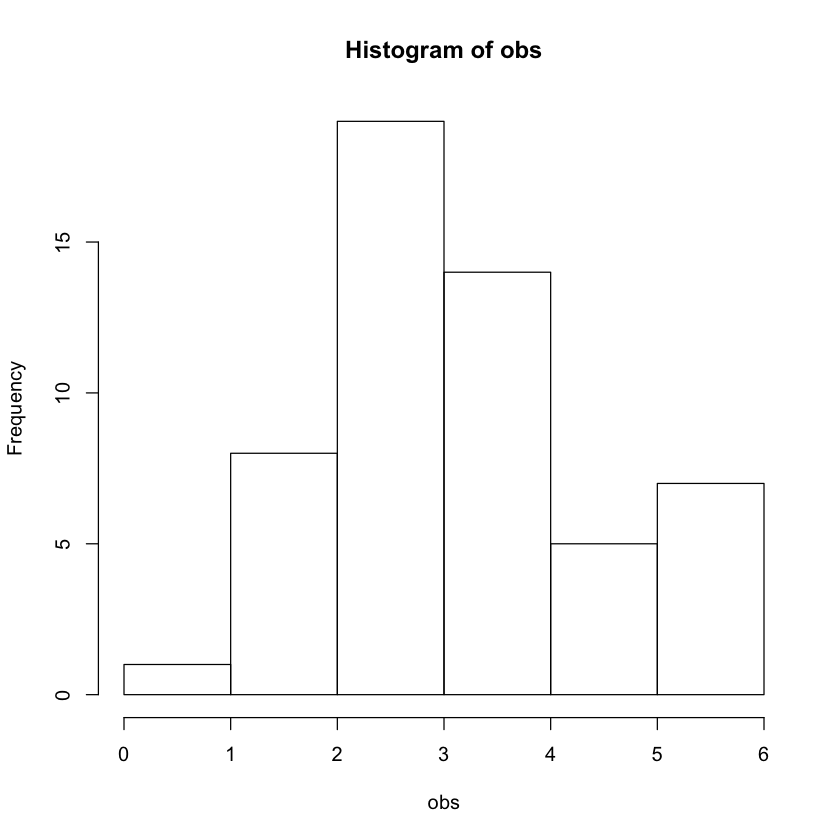

In [360]:
obs <- DrawPDF(100)
hist(obs)

Above is a histogram of the observations.

In [427]:
L <- function(pdf, obs, trange, ll = TRUE) {
    
    # Computes log likelihood as a function of theta (trange)
    #
    # Args:
    #     pdf: input pdf
    #     obs: observations to be used in calculating pdf
    #     trange: range of theta values to plot over
    # Returns:
    #     out: range of theta 
    #
    
    out <- c() #initialize output
    i <- 0 #initialize counter for list index
    
    for (t in trange) { #for every theta
        i <- i + 1
        if (ll == TRUE) { # if you want the log-likelihood
            out[i] <- log(prod(pdf(obs, theta = t), na.rm = TRUE))
        }
        else if (ll == FALSE) {
            out[i] <- prod(pdf(obs, theta = t), na.rm = TRUE)
        }
    }
    
    return(out)
}

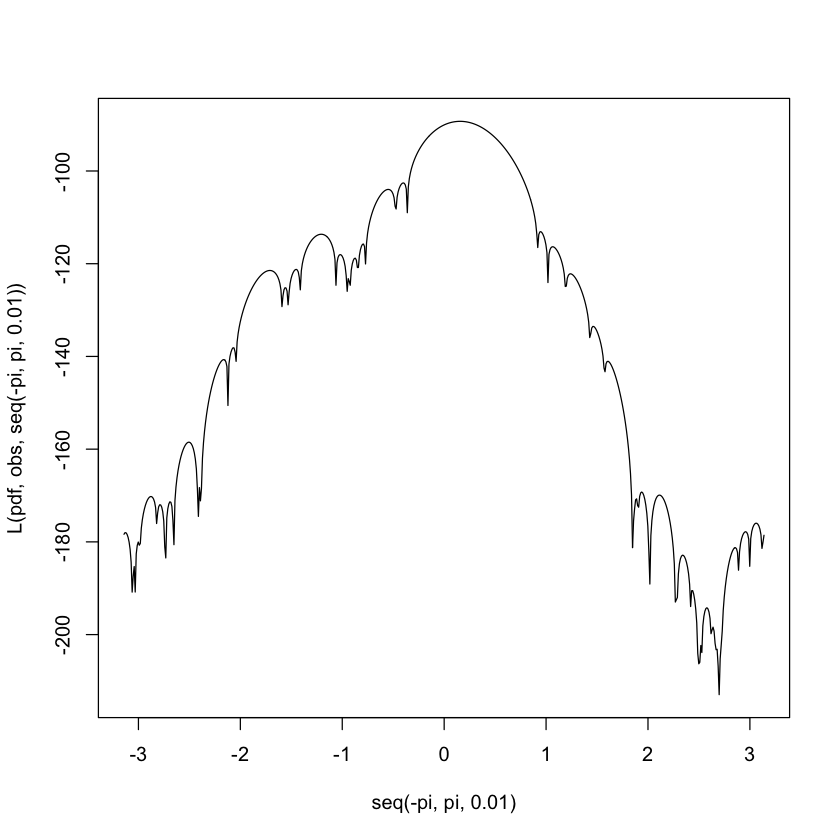

In [525]:
plot(seq(-pi, pi, 0.01),L(pdf,obs, seq(-pi, pi, 0.01)), type = 'l')

This function appears to be at maximum when theta = 0, which makes sense because we used theta = 0 to generate the data!

  ## Part (e)

The iterative process in Newton's method is :

$x_{n+1} = x_{n} - \frac{f(x_{n})}{f'(x_n)}$

So, we need to be able to evaluate the function's 1st derivative and its 2nd derivative at every point. Thankfully we already have these:

$l(\theta) = \log(L(\theta)) = \sum_{i = 1}^{n}\log\Bigg(\frac{1 - \cos(x_{i} - \theta)}{2\pi}\Bigg)$

$\frac{d}{d\theta}\Bigg( \log(L(\theta)) \Bigg) = \sum_{i = 1}^{n} \cot \Bigg(\frac{(x_{i} - \theta)}{2} \Bigg)$

$\frac{d}{d^{2}\theta}\Bigg( \log(L(\theta)) \Bigg) = - \frac{1}{2} \sum^{n}_{i = 1} \csc^{2} \Bigg(\frac{x_{i} - \theta}{2} \Bigg) $


In [454]:
l_theta <- function(theta, obs) {
    
    # calculate log-likelihood of observations, given observations and theta.
    
    terms <- c()
    i <- 0
    
    for (ob in obs) {
        i <- i + 1
        terms[i] <- log((1 - cos(ob - theta))/(2*pi))    
    }
     
    return(sum(terms))
}

dl_theta <- function(theta, obs) {
    
    # calculate 1st derivative log-likelihood of observations, given observations and theta.
    
    terms <- c()
    i <- 0
    
    for (ob in obs) {
        i <- i + 1
        terms[i] <- tan((ob - theta)/(2))^(-1)    
    }
     
    return(sum(terms))
}

ddl_theta <- function(theta, obs) {
    
    # calculate 2nd derivative log-likelihood of observations, given observations and theta.
    
    terms <- c()
    i <- 0
    
    for (ob in obs) {
        i <- i + 1
        terms[i] <- (-1/2)*sin((ob - theta)/(2))^(-2)    
    }
     
    return(sum(terms))
}

In [456]:
NewtonsMethod <- function(ifunc, difunc, x0, obs, tol = 1E-5, maxn = 30) {
    
    # Perform Newton's method to find a root, given the 1st and second derivatives of that function.
    
    x <- c(x0)
    i <- 1
    while (i <= maxn) {
        i <- i + 1
        x[i] <- x[i-1] - (ifunc(x[i-1], na.omit(obs)))/(difunc(x[i-1], na.omit(obs)))
        if (abs(x[i-1] - x[i]) < tol) break
    }
    return(x) 
}

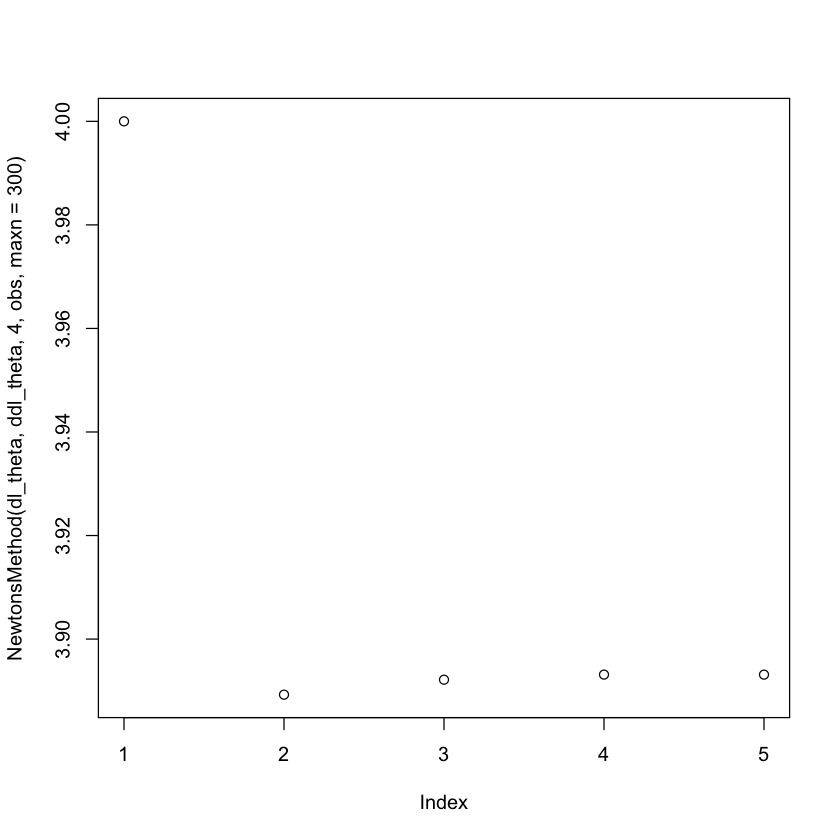

In [463]:
plot(NewtonsMethod(dl_theta, ddl_theta, 4, obs, maxn = 300 ))

As we can see in the plot above, the solver finds and approximate value of a maximum very quickly, however, it is not able to find the global maximum, because there are many local maxima, and the solver just finds the nearest local maximum 😢.